In [1]:
import os
import pickle
import numpy as np
from collections import Counter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def rougeScores(genSummary, refSummary):
    genTotal, refTotal, intersection = 0., 0., 0.
    for token in list(set(list(refSummary.keys()) + list(genSummary.keys()) )):
        intersection += min(refSummary[token], genSummary[token])
        refTotal += refSummary[token]
        genTotal += genSummary[token]

    recall = intersection / refTotal if refTotal > 0. else 0.
    prec   = intersection / genTotal if genTotal > 0. else 0.
    f1 = (2. * recall * prec) / (recall + prec) if (recall + prec) > 0. else 0.
    
    return recall, prec, f1

class LinearRegressor(nn.Module):  # inheriting from nn.Module!
    # calls the init function of nn.Module.  Dont get confused by syntax, always do it in an nn.Module
    def __init__(self, input_size, outputsize, nunits, nlayers):        
        super(LinearRegressor, self).__init__()
        self.nlayers = nlayers
        self.inputlayer = nn.Linear(input_size, nunits)
        self.hiddenlayer= nn.Linear(nunits, nunits)
        self.dense1_bn = nn.BatchNorm1d(nunits)
        self.outputlayer = nn.Linear(nunits, outputsize)
        
    def forward(self, input_vec):
        hiddenlayer = self.inputlayer(input_vec)
        for i in range(self.nlayers):
            hiddenlayer = self.hiddenlayer(hiddenlayer)
        
        return self.outputlayer(self.dense1_bn(hiddenlayer))

class lstmRegressor(nn.Module):  # inheriting from nn.Module!
    # calls the init function of nn.Module.  Dont get confused by syntax, always do it in an nn.Module
    def __init__(self, input_size, outputsize, nunits, nlayers):        
        super(lstmRegressor, self).__init__()
        self.nlayers = nlayers
        self.inputlayer = nn.LSTM(input_size, nunits, num_layers=1)
        self.hiddenlayer= nn.Linear(nunits, nunits)
        self.dense1_bn = nn.BatchNorm1d(nunits)
        self.outputlayer = nn.Linear(nunits, outputsize)
        
    def forward(self, input_vec):
        hiddenlayer = self.inputlayer(input_vec)
        for i in range(self.nlayers):
            hiddenlayer = self.hiddenlayer(hiddenlayer)
        
        return self.outputlayer(hiddenlayer)
#       return self.outputlayer(self.dense1_bn(hiddenlayer))



def buildPredSummary(df, summary, sentence_emb, curr_pred_emb, action, select_index, sent_index):
    if sent_index==0 and action.select(1, select_index).tolist()[0] == 1:
        return sentence_emb, summary + df['sentence'][sent_index]

    if action.select(1, select_index).tolist()[0] == 1:
        # This uses the avergae of the embeddings from the previous 
        # steps...but maybe we should try something different
        return curr_pred_emb * sentence_emb, curr_summary + ' ' + df['sentence'][sent_index]
    
    else:
        return sentence_emb, curr_summary

In [3]:
sdf = pd.read_csv('/home/francisco/GitHub/DQN-Event-Summarization/data/sif/train_000_0.csv')

# Initializing stuff

SKIP = 0
SELECT = 1

true_summary = sdf['summary'][0]
ts_tokenized = Counter(true_summary.split(" "))

nepochs = 500
sif_emb_d = 300

input_dim = 600
outputdim = 2

neurons = 256
nhiddenlayers = 4

rand_rate = 0.50
decay_rate = 0.025

lrate = 0.001
momentum_rate = 0.8

criterion = nn.MSELoss()
nsentences = sdf.index.max()

In [66]:
x0 = [autograd.Variable(torch.randn((1, 3))) for _ in range(5)]
x1 = [autograd.Variable(torch.randn((4, 3))) for _ in range(1)]

In [75]:
# The first axis is the sequence itself
# the second indexes instances in the mini-batch
# the third indexes elements of the input.

lstm0 = nn.LSTM(input_size=3, hidden_size=2, num_layers=2)
linear0 = nn.Linear(2, 2)

In [68]:
# first dimension is sequence size, second dimension is batch size, third dimension is who knows
out0, hidden0 = lstm0(x0[0].view(1, 1, -1))

out1, hidden1 = lstm0(x1[0].view(4, 1, -1))

In [69]:
out1

Variable containing:
(0 ,.,.) = 
  0.0348 -0.1079

(1 ,.,.) = 
  0.0510 -0.1222

(2 ,.,.) = 
  0.0674 -0.1354

(3 ,.,.) = 
  0.0662 -0.1305
[torch.FloatTensor of size 4x1x2]

In [71]:
# Notice this pulls the last state of the sequence
out1[-1]

Variable containing:
 0.0662 -0.1305
[torch.FloatTensor of size 1x2]

In [74]:
linear0(out1[-1])

Variable containing:
 0.5139  0.6232
[torch.FloatTensor of size 1x2]

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)


training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]

word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space)
        return tag_scores


In [ ]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
inputs = prepare_sequence(training_data[0][0], word_to_ix)

sentence = ['Everybody', 'read', 'that', 'book']
tags = ['NN', 'V', 'DET', 'NN']
sentence_in = prepare_sequence(sentence, word_to_ix)
targets = prepare_sequence(tags, tag_to_ix)
tag_scores = model(sentence_in)

In [ ]:
sentence, sentence_in, model(sentence_in)

In [ ]:
emb = nn.Embedding(len(word_to_ix), EMBEDDING_DIM)
lstmemb = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM)
hidden2tag = nn.Linear(HIDDEN_DIM,  len(tag_to_ix))

In [ ]:
# out.view(len(sentence_in), -1) # 4 x 36

out, hidden = lstmemb(emb(sentence_in).view(len(sentence_in), 1, -1))
tag_space = hidden2tag(out.view(len(sentence_in), -1))
tag_scores = F.log_softmax(tag_space)

In [ ]:
tag_scores

In [ ]:
class jointmodel(nn.Module):
    def __init__(self):
        super(jointmodel, self).__init__()
        self.features = nn.Linear(300, 2)

    def forward(self, x, y):
        x1 = self.features(x)
        x2 = self.features(y)
        z = torch.cat((x1, x2), 1)
        return z

In [ ]:
m = jointmodel()

In [ ]:
m(autograd.Variable(sent_emb), autograd.Variable(predsummary_emb))

In [ ]:
sent_index = 0
sent_emb = torch.FloatTensor(sdf[sdf.columns[4:]].values[sent_index, :].reshape(1, sif_emb_d))
train_xs = torch.cat([sent_emb, predsummary_emb], dim=1)

class lstmRegressor(nn.Module):  # inheriting from nn.Module!
    # calls the init function of nn.Module.  Dont get confused by syntax, always do it in an nn.Module
    def __init__(self, input_size, outputsize, nunits, nlayers):        
        super(lstmRegressor, self).__init__()
        self.nunits = nunits
        self.nlayers = nlayers
        
        self.inputlayer = nn.Linear(input_size, nunits)
        self.lstmlayer = nn.LSTM(nunits, nunits, num_layers=1)        
        self.linearlayer= nn.Linear(nunits, nunits)        
        self.hidden = self.init_hidden()
        #self.dense1_bn = nn.BatchNorm1d(nunits)
        
        self.outputlayer = nn.Linear(nunits, outputsize)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(1, 1, self.nunits)),
                autograd.Variable(torch.zeros(1, 1, self.nunits)))
    
    def forward(self, input_vec):
        hiddenlayer = self.inputlayer(input_vec)
        out, hiddenlayer = self.lstmlayer(hiddenlayer, self.hidden)
        hiddenlayer = self.linearlayer(out.view(1, 1, -1))        
        return self.outputlayer(hiddenlayer)

In [ ]:
model = lstmRegressor(input_dim, outputdim, neurons, nhiddenlayers)

In [ ]:
train_xs.shape, neurons, nhiddenlayers, outputdim

In [ ]:
pred = model(autograd.Variable(train_xs))

In [ ]:
pred.view(1, -1)

In [4]:
#model = lstmRegressor(input_dim, outputdim, neurons, nhiddenlayers)
model = LinearRegressor(input_dim, outputdim, neurons, nhiddenlayers)

model.zero_grad()

# swap to ADAM
optimizer = optim.Adam(model.parameters(), lr=lrate)

lossf = {'loss': [], 'sent_idx': [], 'epoch': [], 'action': [], 'f1': [], 'optpred': [], 'rouge_delta':[]}
for epoch in range(nepochs):
    # reset embeddings and summary at the start of training
    f1_t0 = 0.
    curr_summary = ''
    predsummary_emb = torch.from_numpy(np.zeros((1, sif_emb_d))).float()
    
    for sent_index in range(nsentences):        
        model.zero_grad()
        
        # The embeddings start on the 5th column (index 4)
        sent_emb = torch.FloatTensor(sdf[sdf.columns[4:]].values[sent_index, :].reshape(1, sif_emb_d))
        train_xs = torch.cat([sent_emb, predsummary_emb], dim=1)
        train_ys = torch.from_numpy(np.asarray([0]).reshape(1, 1)).float()
        action = torch.from_numpy(np.asarray([0, 0]).reshape(1,2)).int()

        rouge_preds = model(autograd.Variable(train_xs))
        #rouge_preds = model(autograd.Variable(train_xs).view(1, 1, -1))
        qMax, qIndx = rouge_preds.max(dim=1)

        if np.random.uniform() > rand_rate and rand_rate > 0:
            # Randomly choosing either 0 or 1 some percent of hte time
            qIndx = np.random.randint(0, 2, 1)[0]

        action[:, qIndx.data[0]] = 1
        action[:, abs(qIndx.data[0] - 1)] = 0
        
        # building the summary and capturing the embedding
        # without a history model doesn't make a lot of sense
        # not clear what's happening...
        # concatenate summary embedding to input or try separate joining layer like before
        # Worth looking at rougue of each sentence...calculate f1 for each sentence to find out
            # might help figure out what's going on...
        predsummary_emb, curr_summary = buildPredSummary(
                                             sdf, 
                                             curr_summary, 
                                             sent_emb, 
                                             predsummary_emb, 
                                             action, 
                                             SELECT, 
                                             sent_index
                                        )

        recall, prec, f1 = rougeScores(ts_tokenized, Counter(curr_summary.split(" ")))
        
        # Backward part
        predQonActions = torch.masked_select(rouge_preds, autograd.Variable(action.byte()))
        rouge_delta = f1 - f1_t0
        
        # Change in rouge-f1
        train_ys[0] = rouge_delta

        loss = criterion(predQonActions, autograd.Variable(train_ys))
        
        loss.backward()
        optimizer.step()
        
        lossf['loss'].append(loss.data[0])
        lossf['sent_idx'].append(sent_index)
        lossf['epoch'].append(epoch)
        lossf['action'].append(qIndx.data[0])
        lossf['f1'].append(f1)
        lossf['optpred'].append(predQonActions.data[0])
        lossf['rouge_delta'].append(rouge_delta)

        # Storing last round
        f1_t0 = f1 - f1_t0
        
    rand_rate -= decay_rate
    
# Making the performance data a dataframe
perf = pd.DataFrame(lossf)

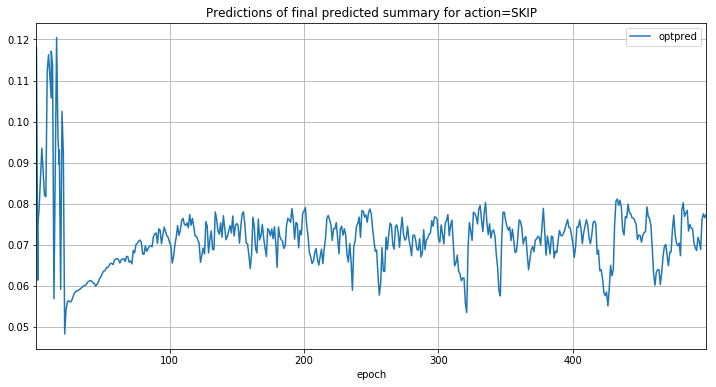

In [5]:
perf[(perf['sent_idx'] == perf['sent_idx'].max() & (perf['action']==0))].plot(
    x='epoch', y='optpred', 
    grid=True,
    figsize=(12, 6),
    title='Predictions of final predicted summary for action=SKIP'
)
plt.show()

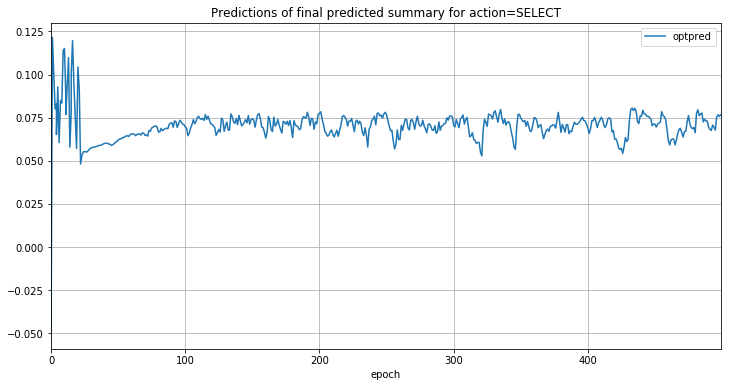

In [6]:
perf[(perf['sent_idx'] == perf['sent_idx'].max() & (perf['action']==1))].plot(
    x='epoch', y='optpred', 
    grid=True,
    figsize=(12, 6),
    title='Predictions of final predicted summary for action=SELECT'
)
plt.show()

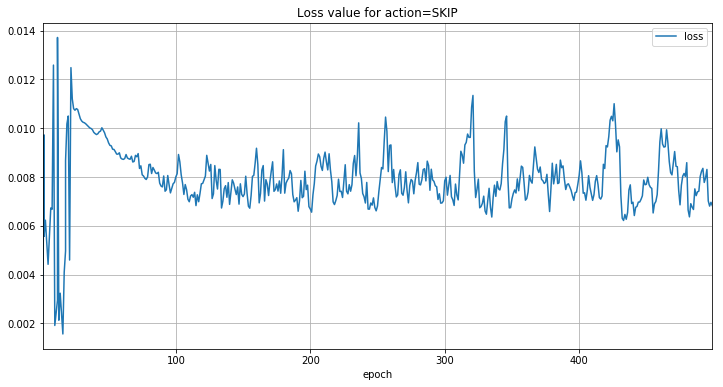

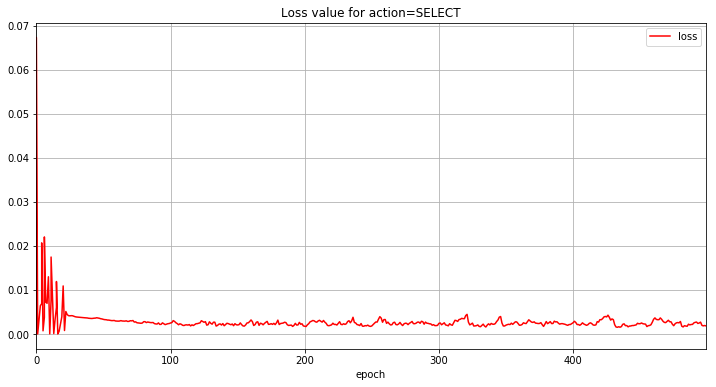

In [7]:
perf[(perf['sent_idx'] == perf['sent_idx'].max() & (perf['action']==0))].plot(
    x='epoch', y='loss', 
    grid=True,
    figsize=(12, 6),
    title='Loss value for action=SKIP'
)
plt.show()
perf[(perf['sent_idx'] == perf['sent_idx'].max() & (perf['action']==1))].plot(
    x='epoch', y='loss', c='red',
    grid=True,
    figsize=(12, 6),
    title='Loss value for action=SELECT'
)
plt.show()

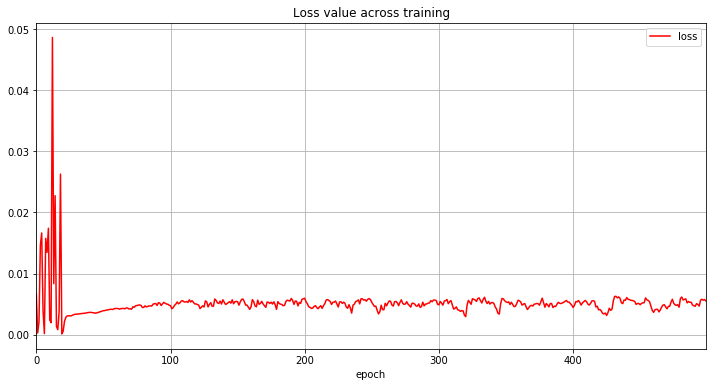

In [8]:

perf[perf['sent_idx'] == perf['sent_idx'].max()].plot(
    x='epoch', y='loss', c='red',
    grid=True,
    figsize=(12, 6),
    title='Loss value across training'
)
plt.show()

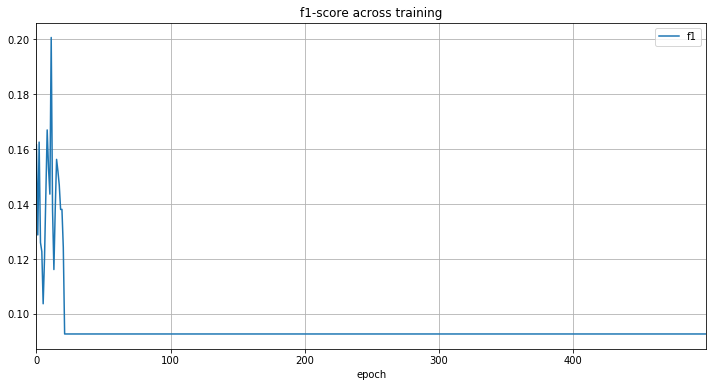

In [9]:
perf[perf['sent_idx'] == perf['sent_idx'].max()].plot(
    x='epoch', y='f1',
    grid=True,
    figsize=(12, 6),
    title='f1-score across training'
)
plt.show()

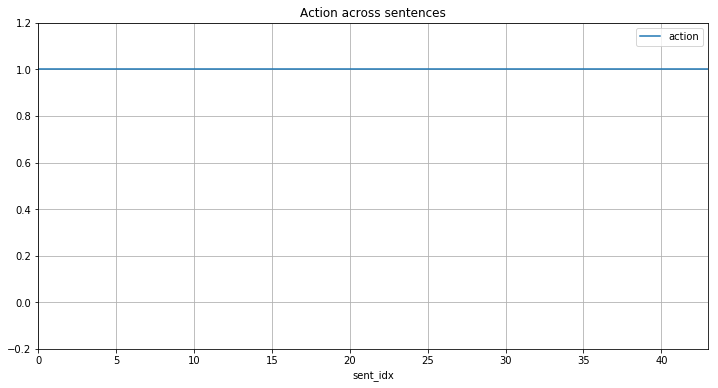

In [10]:
perf[perf['epoch'] == perf['epoch'].max()].plot(
    x='sent_idx', y='action', 
    ylim=[-0.2,1.2],
    grid=True,
    figsize=(12, 6),
    title='Action across sentences'
)
plt.show()

In [11]:
lead3 = ' '.join(sdf['sentence'][0:3])

finalsummary = rougeScores(ts_tokenized, Counter(curr_summary.split(" ")))
baseline = rougeScores(ts_tokenized, Counter(lead3.split(" ")))

print("lead-3  recall = %.3f; precision = %.3f; f1-score = %.3f " % (baseline[0], baseline[1], baseline[2]))

print("learned recall = %.3f; precision = %.3f; f1-score = %.3f " % (finalsummary[0], finalsummary[1], finalsummary[2]))

lead-3  recall = 0.269; precision = 0.375; f1-score = 0.313 
learned recall = 0.049; precision = 0.833; f1-score = 0.093 


In [12]:
lead3

'b"editor \'s note : in our behind the scenes series , cnn correspondents share their experiences in covering news and analyze the stories behind the events . here , soledad o\'brien takes users inside a jail where many of the inmates are mentally ill . an inmate housed on the `` forgotten floor , \'\' where many mentally ill inmates are housed in miami before trial .'

In [13]:
true_summary

'mentally ill inmates in miami are housed on the forgotten floor. judge steven leifman says most are there as a result of avoidable felonies. while cnn tours facility patient shouts i am the son of the president. leifman says the system is unjust and he fighting for change.'

In [14]:
curr_summary

'b"editor \'s note : in our behind the scenes series , cnn correspondents share their experiences in covering news and analyze the stories behind the events . here , soledad o\'brien takes users inside a jail where many of the inmates are mentally ill . an inmate housed on the `` forgotten floor , \'\' where many mentally ill inmates are housed in miami before trial . miami , florida -lrb- cnn -rrb- -- the ninth floor of the miami-dade pretrial detention facility is dubbed the `` forgotten floor . \'\' here , inmates with the most severe mental illnesses are incarcerated until they \'re ready to appear in court . most often , they face drug charges or charges of assaulting an officer -- charges that judge steven leifman says are usually `` avoidable felonies . \'\' he says the arrests often result from confrontations with police . mentally ill people often wo n\'t do what they \'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become m